In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 25.0 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Định nghĩa đường dẫn thư mục
SAVE_PATH = "../_static/demonstration_assets/quanvolution/"

# Tạo thư mục nếu chưa tồn tại
os.makedirs(SAVE_PATH, exist_ok=True)

print(f"Folder created or already exists at: {SAVE_PATH}")

Folder created or already exists at: ../_static/demonstration_assets/quanvolution/


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# cifar10_dataset = keras.datasets.cifar10
# (train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()

# # Chuyển đổi ảnh huấn luyện sang grayscale
# train_images = tf.image.rgb_to_grayscale(train_images)
# train_labels = tf.squeeze(train_labels, axis=1)

# # Chuyển đổi ảnh kiểm tra sang grayscale (nếu cần)
# test_images = tf.image.rgb_to_grayscale(test_images)
# test_labels = tf.squeeze(test_labels, axis=1)

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# print(train_images[0])
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255
# print(train_images[0])
# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# train_images = np.array(train_images[..., tf.newaxis])
# test_images = np.array(test_images[..., tf.newaxis])

# Kiểm tra
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (50, 28, 28, 1)
Train labels shape: (50,)
Test images shape: (30, 28, 28, 1)
Test labels shape: (30,)


In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
# def quanv(image):
#     """Convolves the input image with many applications of the same quantum circuit."""
#     out = np.zeros((16, 16, 4))

#     # Loop over the coordinates of the top-left pixel of 2X2 squares
#     for j in range(0, 32, 2):
#         for k in range(0, 32, 2):
#             # Process a squared 2x2 region of the image with a quantum circuit
#             q_results = circuit(
#                 [
#                     image[j, k, 0],
#                     image[j, k + 1, 0],
#                     image[j + 1, k, 0],
#                     image[j + 1, k + 1, 0]
#                 ]
#             )
#             # Assign expectation values to different channels of the output pixel (j/2, k/2)
#             for c in range(4):
#                 out[j // 2, k // 2, c] = q_results[c]
#     return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)
    print(q_train_images[0])

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
[[[ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]]

 [[ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346

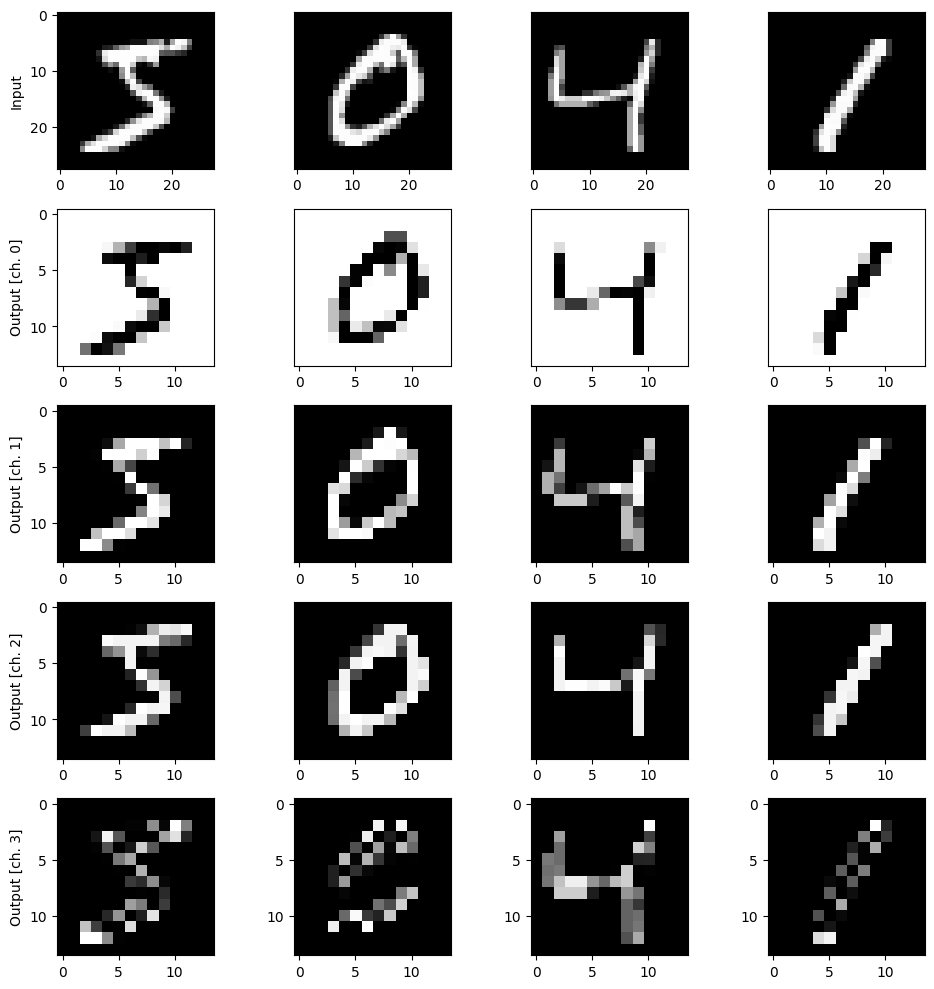

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 73ms/step - accuracy: 0.1600 - loss: 2.8028 - val_accuracy: 0.1333 - val_loss: 2.3226
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.4400 - loss: 1.8883 - val_accuracy: 0.2667 - val_loss: 2.0875
Epoch 3/30
13/13 - 0s - 26ms/step - accuracy: 0.6800 - loss: 1.5491 - val_accuracy: 0.4333 - val_loss: 1.8504
Epoch 4/30
13/13 - 0s - 21ms/step - accuracy: 0.7600 - loss: 1.2200 - val_accuracy: 0.5333 - val_loss: 1.6925
Epoch 5/30
13/13 - 0s - 23ms/step - accuracy: 0.9000 - loss: 0.9816 - val_accuracy: 0.5333 - val_loss: 1.5753
Epoch 6/30
13/13 - 0s - 23ms/step - accuracy: 0.9200 - loss: 0.8049 - val_accuracy: 0.5667 - val_loss: 1.4835
Epoch 7/30
13/13 - 0s - 25ms/step - accuracy: 0.9200 - loss: 0.6689 - val_accuracy: 0.6000 - val_loss: 1.4081
Epoch 8/30
13/13 - 0s - 14ms/step - accuracy: 0.9800 - loss: 0.5605 - val_accuracy: 0.6000 - val_loss: 1.3430
Epoch 9/30
13/13 - 0s - 24ms/step - accuracy: 0.9800 - loss: 0.4754 - val_accuracy: 0.6000 - val_loss: 1.2923
Epoch 10/3

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 69ms/step - accuracy: 0.1000 - loss: 2.4337 - val_accuracy: 0.0667 - val_loss: 2.3712
Epoch 2/30
13/13 - 0s - 34ms/step - accuracy: 0.4000 - loss: 2.0310 - val_accuracy: 0.3333 - val_loss: 2.2039
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5800 - loss: 1.7460 - val_accuracy: 0.3667 - val_loss: 2.0543
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7000 - loss: 1.5055 - val_accuracy: 0.4000 - val_loss: 1.9226
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8200 - loss: 1.3018 - val_accuracy: 0.4000 - val_loss: 1.8105
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.8600 - loss: 1.1305 - val_accuracy: 0.4667 - val_loss: 1.7165
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.9868 - val_accuracy: 0.4667 - val_loss: 1.6378
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.8662 - val_accuracy: 0.4667 - val_loss: 1.5711
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 0.9600 - loss: 0.7645 - val_accuracy: 0.5000 - val_loss: 1.5142
Epoch 10/30


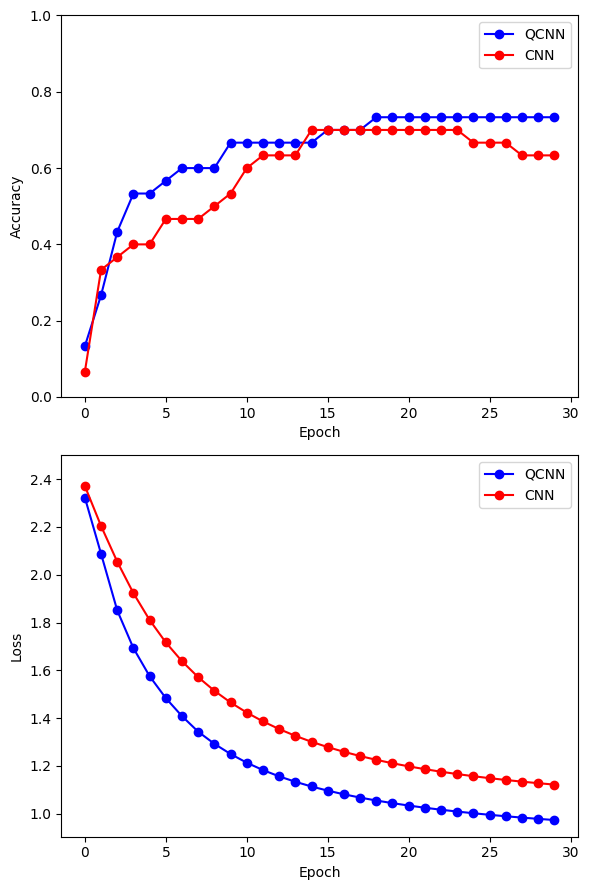

In [ ]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="QCNN")
ax1.plot(c_history.history["val_accuracy"], "-or", label="CNN")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="QCNN")
ax2.plot(c_history.history["val_loss"], "-or", label="CNN")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()